In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import numpy as np
import anndata as ad
from tqdm import tqdm

# from jax.config import config
# config.update("jax_enable_x64", True)

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/DataUpload")
dataset = 14
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

# adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
# adata_sp_a = adata_sp.copy()
# adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
adata_sp_b = adata_sp.copy()
sc_count = pd.read_csv(
    path_read / f"Dataset{dataset}" / "scRNA_count.txt", sep="\t", header=0, index_col=0
).T
adata_sp_a = AnnData(csr_matrix(sc_count.to_numpy()), dtype=sc_count.to_numpy().dtype)
adata_sp_a.var_names = sc_count.columns.tolist()
sc.pp.filter_cells(adata_sp_a, min_counts=10)
sc.pp.filter_genes(adata_sp_a, min_counts=2)
adata_sp_a.layers["counts"] = adata_sp_a.X.copy()
if adata_sp_a.shape[1] > 5000:
    sc.pp.highly_variable_genes(
        adata_sp_a, flavor="seurat_v3", n_top_genes=2000, subset=True
    )
sc.pp.normalize_total(adata_sp_a)
sc.pp.log1p(adata_sp_a)

intersect_var = list(set(adata_sp_a.var_names).intersection(set(adata_sp_b.var_names)))

# adata_sp_a = adata_sp_a[:, intersect_var].copy()
adata_sp_b = adata_sp_b[:, intersect_var].copy()

test_var = rng.choice(adata_sp_b.var_names, n_genes, replace=False).tolist() + ["eve"]
train_var = adata_sp_b.var_names[~np.in1d(adata_sp_b.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [8]:
adata_sc = adata_sp_a.copy()
adata_sp = adata_sp_b.copy()

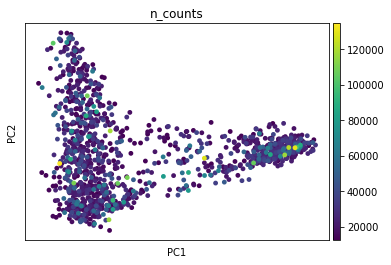

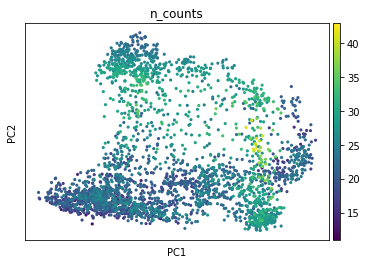

In [10]:
sc.pl.pca(adata_sc, color="n_counts")
sc.pl.pca(adata_sp, color="n_counts")

In [11]:
adata_sc.write(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/moscot_datasets/adata_dm_sc.h5ad"
)
adata_sp.write(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/moscot_datasets/adata_dm_sp.h5ad"
)

In [12]:
adata_sim = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [32]:
adata_sim.obs.synth_batch.value_counts()

2    3200
3    3200
6    3200
7    3200
0     800
1     800
4     800
5     800
Name: synth_batch, dtype: int64

In [73]:
from math import cos, sin

adata_0 = adata_sim[adata_sim.obs.synth_batch == "4"].copy()
adata_2 = adata_0[adata_0.obs.batch == 0].copy()
adata_0 = adata_0[adata_0.obs.batch == 1].copy()
adata_1 = adata_sim[adata_sim.obs.synth_batch == "5"].copy()
adata_1 = adata_1[adata_1.obs.batch == 0].copy()
angle = 30
theta = np.deg2rad(angle)
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
adata_1.obsm["spatial"] = np.dot(adata_1.obsm["spatial"], rot) + 3

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


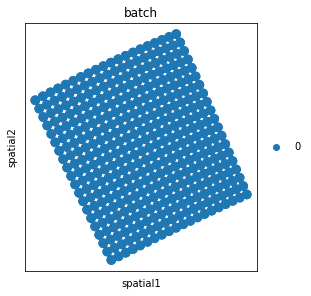

In [74]:
sq.pl.spatial_scatter(adata_1, color="batch", shape=None)

In [75]:
adata_0.obs.drop(columns=["idx", "synth_batch", "batch"], inplace=True)
adata_1.obs.drop(columns=["idx", "synth_batch", "batch"], inplace=True)
adata_2.obs.drop(columns=["idx", "synth_batch", "batch"], inplace=True)

In [76]:
adata = ad.concat([adata_0, adata_1, adata_2], keys=["0", "1", "2"], label="batch")
adata.obs_names_make_unique()

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [77]:
adata.uns = {}
adata.obs["batch"].cat.categories

Index(['0', '1', '2'], dtype='object')

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


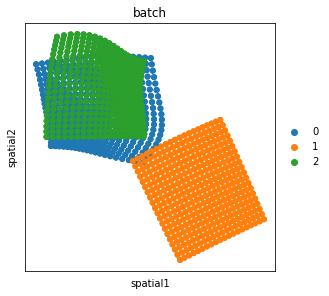

In [78]:
sq.pl.spatial_scatter(adata, color="batch", shape=None)

In [81]:
adata.write(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/moscot_datasets/adata_alignment_sim.h5ad"
)

In [82]:
adata.shape

(1200, 500)

In [83]:
adata_sc.shape

(1297, 2000)

In [84]:
adata_sp.shape

(3039, 82)